# AWS Sagemaker Project: Mushroom

The goal of our project is to determine if a mushroom is edible or not based on several attributes.

### Table of content  
 1. [Introduction](#Introduction)
 2. [Data analysis](#Datanalysis)
 3. [Domain Application](#Domainapplication)
 4. [Data scaling & transformation](#Datascaling)
 5. [Data Visualization](#Datavisualization)
 6. [Dataset split into train test and validation sets](#Datasplit)
 7. [Dataset storage in an S3 compartment](#Datastorage)
 8. [Model creation and training](#Modelcreation)
 9. [Check feature importance in the model](#Checkfeature)
 10. [Make predictions and evaluate the model](#Makepredictions)
 11. [Conclusion](#Conclusion)
 
 ---


<div id='Introduction'/>

## 1. Introduction

In order to understand the dataset and the main issue to solve, here is a small representation of a mushroom anatomy:

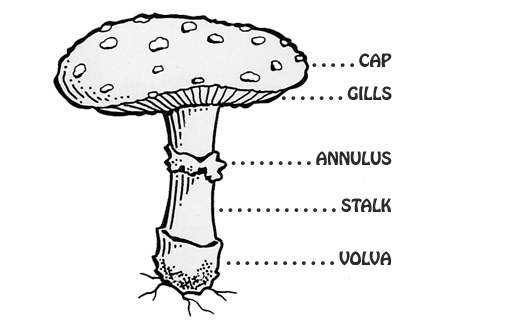

From the image, we can say that we have 5 main features of the mushroom:
- Cap: which is the top part of the mushroom from above, which takes the umberlla shape.
- Gill: which is the underside of the cap
- Ring (Annulus): which is this little shape that surround the stem (stalk).
- Stalk: is what makes the mushroom standing, it's this vertical cylindrical.
- Veil (Volva): which is the bottom shape of the mushroom, that covers the bottom part of the mushroom.


In this project, we will try to use the principle of **cross-validation**.
It is a method of estimating the reliability of a model based on a sampling technique.

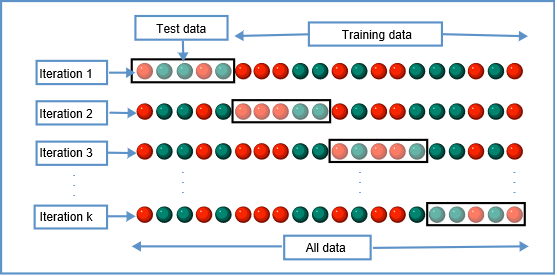

As you can see in the image, the idea is to do several training sessions of the model by dragging the test set, like a sliding window, on the train set.

This method can be used either to establish a more **precise performance** of a model by calculating the average of all the trainings, or to test different parameters in a grid search to find the **optimal configuration** before submitting the validation data set.

In [1]:
import time
start_time = time.time()

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, confusion_matrix, roc_curve
import scipy.stats as ss
import xgboost as xgb

import os
from io import StringIO, BytesIO
import tarfile
import pickle as pkl

import boto3
import sagemaker
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker import get_execution_role
from sagemaker.predictor import csv_serializer
from sagemaker.estimator import Estimator

pd.set_option('display.max_columns', 23)

In [3]:
s3client = boto3.client(
    's3',
    region_name='us-west-1'
)

bucket = 'project-sagemaker-aws'
file_to_read = 'raw/mushrooms.csv' 

fileobj = s3client.get_object(Bucket=bucket, Key=file_to_read)
df = pd.read_csv(BytesIO(fileobj['Body'].read()))

<div id='Datanalysis'/>

## 2. Data analysis

In [4]:
df.shape

(8124, 23)

In [5]:
df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,e,e,s,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,e,c,s,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,e,c,s,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,e,e,s,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,t,e,s,s,w,w,p,w,o,e,n,a,g


In [6]:
df.describe()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
count,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124
unique,2,6,4,10,2,9,2,2,2,12,2,5,4,4,9,9,1,4,3,5,9,6,7
top,e,x,y,n,f,n,f,c,b,b,t,b,s,s,w,w,p,w,o,p,w,v,d
freq,4208,3656,3244,2284,4748,3528,7914,6812,5612,1728,4608,3776,5176,4936,4464,4384,8124,7924,7488,3968,2388,4040,3148


In [7]:
for col in df.columns:
    print("\n---- %s ---" % col)
    print(df[col].value_counts(dropna=False))


---- class ---
e    4208
p    3916
Name: class, dtype: int64

---- cap-shape ---
x    3656
f    3152
k     828
b     452
s      32
c       4
Name: cap-shape, dtype: int64

---- cap-surface ---
y    3244
s    2556
f    2320
g       4
Name: cap-surface, dtype: int64

---- cap-color ---
n    2284
g    1840
e    1500
y    1072
w    1040
b     168
p     144
c      44
u      16
r      16
Name: cap-color, dtype: int64

---- bruises ---
f    4748
t    3376
Name: bruises, dtype: int64

---- odor ---
n    3528
f    2160
y     576
s     576
l     400
a     400
p     256
c     192
m      36
Name: odor, dtype: int64

---- gill-attachment ---
f    7914
a     210
Name: gill-attachment, dtype: int64

---- gill-spacing ---
c    6812
w    1312
Name: gill-spacing, dtype: int64

---- gill-size ---
b    5612
n    2512
Name: gill-size, dtype: int64

---- gill-color ---
b    1728
p    1492
w    1202
n    1048
g     752
h     732
u     492
k     408
e      96
y      86
o      64
r      24
Name: gill-color, d

In [8]:
df = df.drop(["veil-type", "stalk-root"], axis=1)

The data set consists of more than 8000 rows and 22 all categorical variables.
It is a binary classification problem where the goal is determining whether a mushroom is edible or not.

We notice two things about the description of the variables:
- the variable __veil-type__ has only one value, so we can remove it.
- the variable __stalk-root__ can have the value "?" which corresponds a priori to a missing value.
First, since we have many other variables, we can also remove it.

For the others we have between 2 and 12 values, some are poorly represented (ex: cap-shape = c => 4/8124) but never unique, so we do not consider them as anomalies.

Text(0.5, 1.0, 'Number of poisonous/edible mushrooms (e=edible, p=poisonous)')

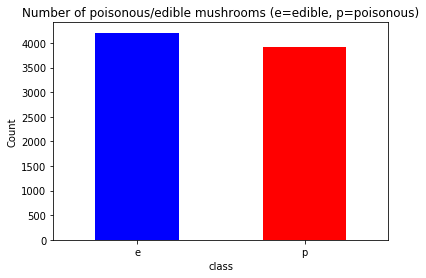

In [9]:
plt.figure()
pd.Series(df['class']).value_counts().sort_index().plot(kind='bar', color=('b','r'))
plt.ylabel("Count")
plt.xlabel("class")
plt.xticks(rotation=0)
plt.title('Number of poisonous/edible mushrooms (e=edible, p=poisonous)')

We check here that data are generally well distributed between the 2 classes.

In [10]:
# https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V
# https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9

def cramers_v(df):
    corr_mat = pd.DataFrame(np.eye(df.shape[1]), df.columns, df.columns)
    for col_A in df:
        for col_B in df.drop(col_A, axis=1):
            confusion_matrix = pd.crosstab(df[col_A], df[col_B])
            chi2 = ss.chi2_contingency(confusion_matrix)[0]
            n = confusion_matrix.sum().sum()
            phi2 = chi2 / n
            r, k = confusion_matrix.shape
            phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
            rcorr = r - ((r - 1) ** 2) / (n - 1)
            kcorr = k - ((k - 1) ** 2) / (n - 1)
            corr_mat[col_A][col_B] = np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))
    return corr_mat

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5]),
 <a list of 21 Text xticklabel objects>)

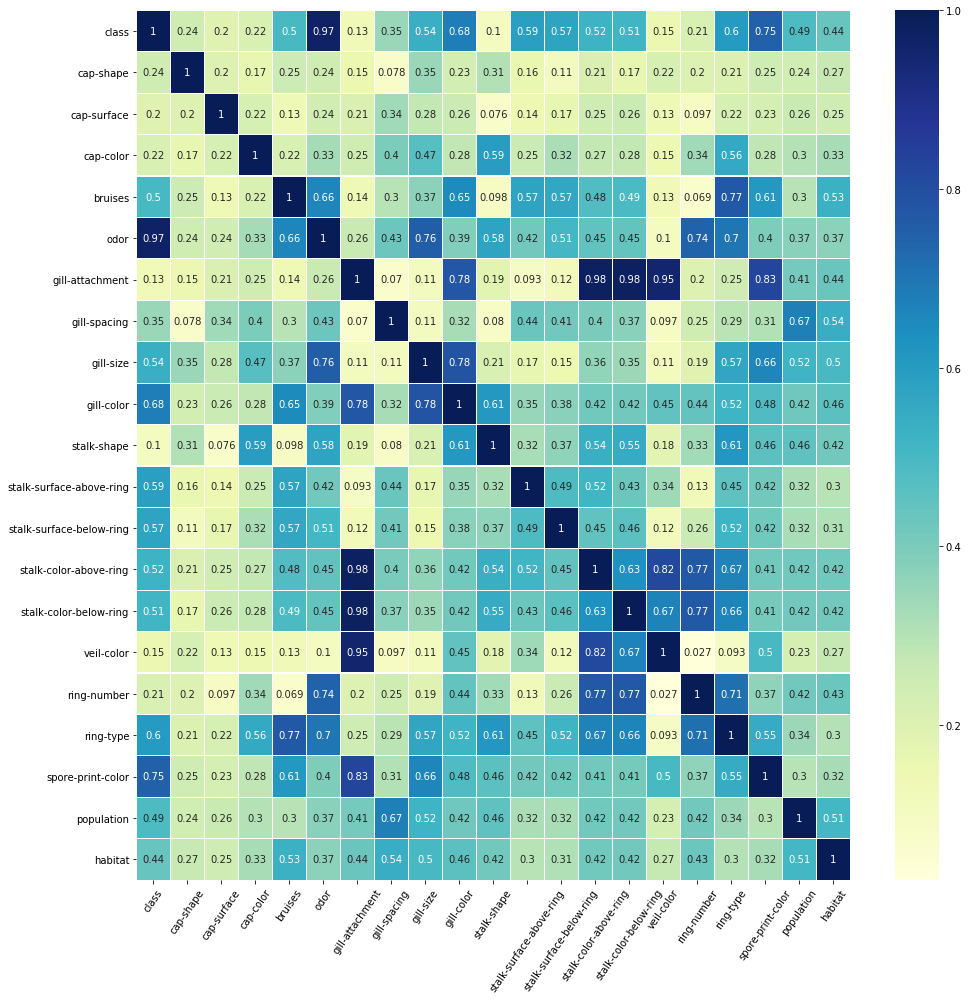

In [11]:
plt.figure(figsize=(16, 16))
sns.heatmap(cramers_v(df), linewidths=.1, cmap="YlGnBu", annot=True)
plt.yticks(rotation=0)
plt.xticks(rotation=55)

We are looking for correlations between the different variables.

We cannot use the classic correlation matrix (using the Pearson test) since these are categorical / nominal variables.



However, we can calculate the Cramér's V index to determine the association between two variables. The interpretation remains the same as for a correlation matrix except that the values are only positive \[0, 1\].


---

In the matrix, we notice that the __class__ (variable to predict) is strongly associated with the feature __odor__ (97%): it is therefore a feature that we will have to keep an eye on and monitor.


Moreover, the feature __gill-attachment__ is strongly associated with __veil-color__, __stalk-color-above-ring__ and __stalk-color-below-ring__.
If necessary, we could remove these last three variables since the data are already mostly represented by the first one.

<div id='Domainapplication'/>

## 3. Analysis of the domain application 

The main objective here is to differentiate an edible mushroom from a poisonous one based on its features.
One can imagine, for example, a mobile application that hikers would use when going through the forest to ensure that the picked mushrooms are edible.

<div id='Datascaling'/>

## 4. Data scaling & transformation

To transform the categorical variables, we could use one hot encoding or label encoding for example.

To scale the data, normalization or standardization could be applied among other methods.

We focus on One Hot Encoding and Standardization here.

In [12]:
# We split features from labels to apply transformations
X = df.drop(['class'], axis=1)
Y = df['class']

In [13]:
# We apply One Hot Encoding via dummy variables for each column in X.
X_dummy = pd.get_dummies(X, drop_first=True)
print('Number of columns generated from dummy variables =', len(X_dummy.columns.values),'Columns')

Number of columns generated from dummy variables = 91 Columns


In [14]:
# We use here standardization which is a prerequisite for PCA and helpful for xgboost
X_std = StandardScaler().fit_transform(X_dummy.astype(float))

We use One Hot Encoding rather than Label Encoding since the latter is less precise for algorithms linked to decision trees (Random Forest, XGBoost, etc.)

Similarly, standardization is used to obtain a centered and reduced dataset.
This allows us to use both the ACP (prerequisite) and to save computation time as well as to prevent certain side effects or undesirable that algorithms can have on variables of different scales.


We could also have used a MinMaxScaler, a Normalizer or a QuantileTransformer to transform the data.
However the first does not produce a standardized data and the other two are non-linear transformations which can modify the intrinsic structure of the data if they are not used in the right conditions. We therefore opted for standardization.

<div id='Datavisualization'/>

## 5. Data Visualization

Using dimensionality reduction

We apply PCA to the dataset, reducing its feature number to 2 to allow visualization.

In [15]:
X_pca = PCA(n_components=2).fit_transform(X_std)

print('Original Number of features =',  X_dummy.shape[1] ,'columns')
print('Reduced Number of features =', X_pca.shape[1], 'columns')

Original Number of features = 91 columns
Reduced Number of features = 2 columns


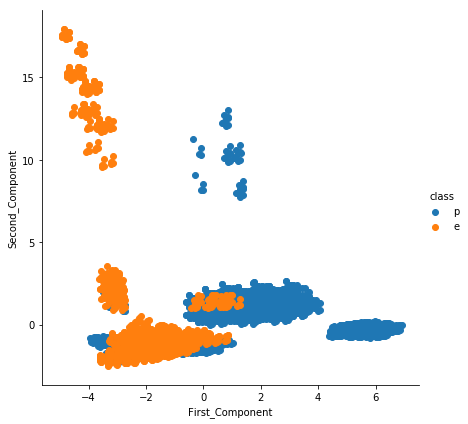

In [16]:
# Attach the label for each 2-d data point
X_pca = np.vstack((X_pca.T, Y)).T

df_pca = pd.DataFrame(X_pca, columns=['First_Component',
                                      'Second_Component',
                                      'class'])
sns.FacetGrid(data=df_pca, hue='class', height=6)\
   .map(plt.scatter, 'First_Component', 'Second_Component')\
   .add_legend()

The two main classes (edible and poisonous) are displayed here in orange and blue.

While some clusters are easily separable from the rest of the dataset, others are overlapping. Therefore we cannot be sure that the model will perform well and we're looking for the best prediction possible.

When we increase the number of principale components, PCA will do a better job distinguishing between them and reduce the overlapping, but unfortunatly we won't be able to visualize.

Text(0, 0.5, 'Cumulative Explained Variance')

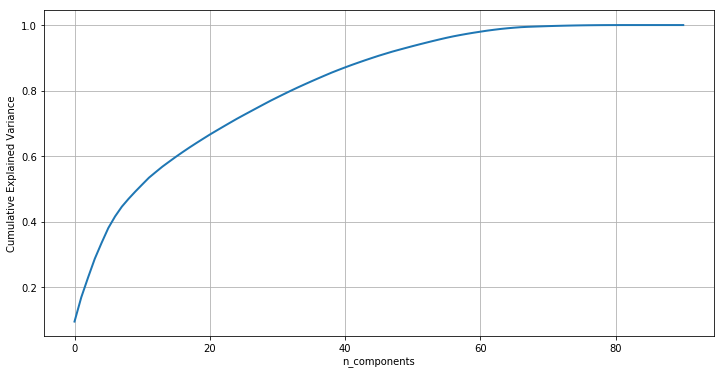

In [17]:
# We compute again PCA but with the same number of component, therefore we will be able to sort compnents according to the data variance they contain
# And therefore reduce the dataset dimensionality
pca = PCA(n_components=91)
X_pca = pca.fit_transform(X_std)

percent_var_explained = pca.explained_variance_ / np.sum(pca.explained_variance_)

cum_var_explained = np.cumsum(percent_var_explained)

# Plot the PCA Spectrum
plt.figure(1, figsize=(12, 6))
plt.clf()
plt.plot(cum_var_explained, linewidth=2)
plt.axis('tight')
plt.grid()
plt.xlabel('n_components')
plt.ylabel('Cumulative Explained Variance')

In [18]:
# Create a PCA that will retain 95 of the variance%
pca = PCA(n_components=0.95, whiten=True)

# Conduct PCA
X_pca = pca.fit_transform(X_std)

# Show the result
print('Original number of features:', X_dummy.shape[1])
print('Reduced number of features:', X_pca.shape[1])

Original number of features: 91
Reduced number of features: 54


Using this PCA we know from now on that we could drop about a third of the data, and only losing a small part of the information.

But we need to improve the visualization part. In order to do that, we decided to try another dimensionality reduction technique: t-SNE.

In [19]:
tsne = TSNE(n_components=2, random_state=0)

X_tsne = tsne.fit_transform(X_std)

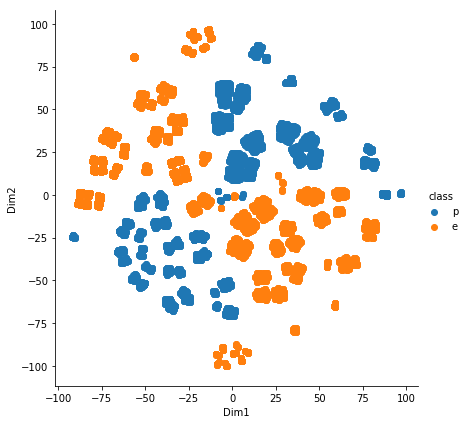

In [20]:
# Create the dataframe to plot
X_tsne_data = np.vstack((X_tsne.T, Y)).T
df_tsne = pd.DataFrame(X_tsne_data, columns=['Dim1', 'Dim2', 'class'])

# Plot the 2 components from t-SNE
sns.FacetGrid(df_tsne, hue='class', height=6)\
   .map(plt.scatter, 'Dim1', 'Dim2')\
   .add_legend()

This is much more separable than the PCA. Fortunately we can now say that we could find a model able to predict well the class of mushrooms.

But first we need to split the dataset.

<div id='Datasplit'/>

## 6. Dataset split into train test and validation sets

Sagemaker needs a validation set to compute the metrics while training, thus allows to compare several models according to the validation results.

Therefore we need a third set to test the final performance of the model, like new and unknown data in a production like environment.

In [21]:
df = pd.concat([(Y == "e").astype(int), pd.DataFrame(X_std, columns=X_dummy.columns)], axis=1)

In [22]:
temp_set, valid_set = train_test_split(df, test_size=0.2)
train_set, test_set = train_test_split(temp_set, test_size=0.25)

In [23]:
print('Training dataset: {}'.format(train_set.shape))
print('Validation dataset: {}'.format(valid_set.shape))
print('Test dataset: {}'.format(test_set.shape))

Training dataset: (4874, 92)
Validation dataset: (1625, 92)
Test dataset: (1625, 92)


<div id='Datastorage'/>

## 7. Dataset storage in an S3 compartment

In [24]:
data_partitions = [('train', train_set), ('validation', valid_set), ('test', test_set)]
for data_partition_name, data_partition in data_partitions:
    print('{}: {}'.format(data_partition_name, data_partition.shape))

    np.savetxt('data.csv', data_partition, delimiter=',')
    key = "{}/examples".format(data_partition_name)
    url = 's3://{}/{}'.format(bucket, key)
    s3client.upload_file('data.csv', bucket, key)
    print('Done writing to {}'.format(url))
os.remove("data.csv")

train: (4874, 92)
Done writing to s3://project-sagemaker-aws/train/examples
validation: (1625, 92)
Done writing to s3://project-sagemaker-aws/validation/examples
test: (1625, 92)
Done writing to s3://project-sagemaker-aws/test/examples


<div id='Modelcreation'/>

## 8. Model creation and training

We start by pushing the datasets to S3 which will be the source folders for Sagemaker services.

In [25]:
train_data = 's3://{}/{}'.format(bucket, 'train')

validation_data = 's3://{}/{}'.format(bucket, 'validation')

s3_output_location = 's3://{}/{}'.format(bucket, 'xgboost_model_sdk')

Then we create an estimator based on AWS XGBoost image, we configure it with basic hyperparameters and start the training.

In [26]:
container = get_image_uri(boto3.Session().region_name, 'xgboost')

	get_image_uri(region, 'xgboost', '0.90-1').


In [27]:
role = get_execution_role()

In [28]:
xgb_model = Estimator(container,
                     role, 
                     train_instance_count=1, 
                     train_instance_type='ml.m4.xlarge',
                     train_volume_size = 5,
                     output_path=s3_output_location,
                     sagemaker_session=sagemaker.Session())

In [29]:
xgb_model.set_hyperparameters(objective = "binary:logistic",
                              num_round = 20,
                              verbosity = 2)

In [30]:
train_channel = sagemaker.session.s3_input(train_data, content_type='text/csv')
valid_channel = sagemaker.session.s3_input(validation_data, content_type='text/csv')

data_channels = {'train': train_channel, 'validation': valid_channel}

In [31]:
xgb_model.fit(inputs=data_channels, logs=True)

2020-02-11 15:07:32 Starting - Starting the training job...
2020-02-11 15:07:33 Starting - Launching requested ML instances...
2020-02-11 15:08:30 Starting - Preparing the instances for training.........
2020-02-11 15:09:36 Downloading - Downloading input data...
2020-02-11 15:10:32 Training - Training image download completed. Training in progress.
2020-02-11 15:10:32 Uploading - Uploading generated training model.Arguments: train
[2020-02-11:15:10:27:INFO] Running standalone xgboost training.
[2020-02-11:15:10:27:INFO] File size need to be processed in the node: 14.72mb. Available memory size in the node: 8536.12mb
[2020-02-11:15:10:27:INFO] Determined delimiter of CSV input is ','
[15:10:27] S3DistributionType set as FullyReplicated
[15:10:27] 4874x91 matrix with 443534 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2020-02-11:15:10:27:INFO] Determined delimiter of CSV input is ','
[15:10:27] S3DistributionType set as FullyReplicated
[15:10:27] 1

The training is complete.

It is impressive, the model seems to have achieve a 0% error rate on the validation set.

We will need to test it with new data to be sure.

---

The model has been trained in a EC2 instance and is now stored in S3.

We can fetch it and load it to reuse it if necessary.

<div id='Checkfeature'/>

## 9. Check feature importance in the model

For example, if we want some interpretability, we can load the model and check for feature importance.

In [32]:
model_path = xgb_model.model_data.split('/', 3)[3]
model_file = model_path.rpartition('/')[2]
s3client.download_file(bucket, model_path, model_file)

tar = tarfile.open('model.tar.gz')
tar.extractall()
tar.close()
os.remove('model.tar.gz')

model = pkl.load(open('xgboost-model', 'rb'))

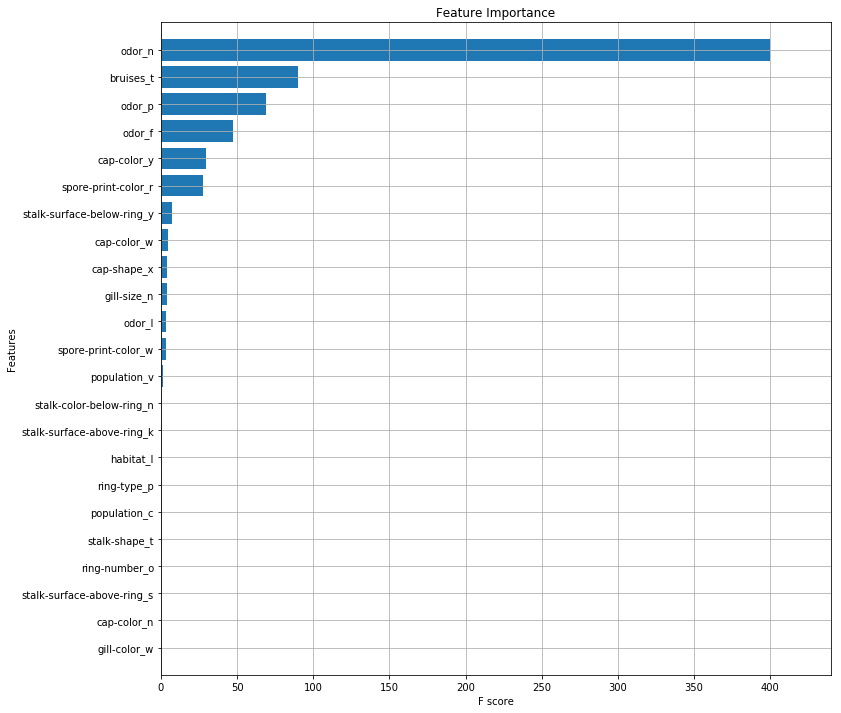

In [33]:
map_names = dict(zip(model.feature_names, train_set.drop(['class'], axis=1).columns))
model.feature_names = list(map_names.values())

#plot feature importance
fig, ax = plt.subplots(figsize=(12,12))
xgb.plot_importance(model, importance_type='gain', max_num_features=30, height=0.8, ax=ax, show_values = False)
plt.title('Feature Importance')
plt.show()
os.remove('xgboost-model')

As we said in Data Analysis section, the __odor__ feature seems to be important.

We can see here that among the 5 most important features, 3 of them are __odor__ categories.

The correlation matrix was right !

<div id='Makepredictions'/>

## 10. Make predictions and evaluate the model

Now we deploy the model on an aws endpoint, fetch the stored test set and send it to the model to make prediction.

In [34]:
xgb_predictor = xgb_model.deploy(initial_instance_count = 1, instance_type = 'ml.m4.xlarge')

# Data format expected from the predictor
xgb_predictor.content_type = 'text/csv'
xgb_predictor.serializer = csv_serializer
xgb_predictor.deserializer = None

-----------!

In [35]:
# Function to format test set
def predict(data, model):
    split_array = np.array_split(data, data.shape[0])
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, model.predict(array).decode('utf-8')])

    return np.fromstring(predictions[1:], sep=',')

# Generate predictions on the test set
predictions = predict(test_set.drop(['class'], axis=1).values, xgb_predictor)

Text(0.5, 15.0, 'Predicted label')

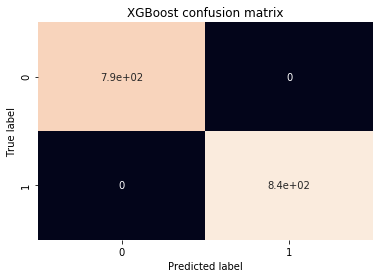

In [36]:
# The prediction is a probability: 0<p<1
# We simply set the threshold to 0.5
y_pred = (predictions > 0.5).astype(int)
cfm = confusion_matrix(test_set['class'], y_pred)

sns.heatmap(cfm, annot=True, cbar=False)
plt.title('XGBoost confusion matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')

The confusion matrix is perfect ! Every prediction is correct, no false positive or false negative.

The model is well trained and ready for production.

It is not necessary here but in order to evaluate its performance we could also see the AUC (Area Under roc Curve) indicator.

AUC is 1.0


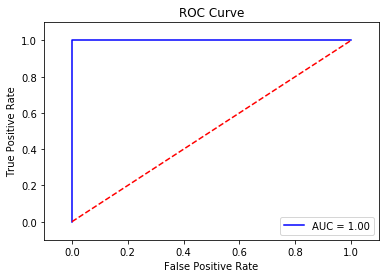

In [37]:
auc = round(roc_auc_score(test_set['class'], y_pred), 4)
print('AUC is ' + repr(auc))

fpr, tpr, _ = roc_curve(test_set['class'], y_pred)

plt.title('ROC Curve')
plt.plot(fpr, tpr, 'b',
label='AUC = %0.2f'% auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

The AUC shows the evolution of True and False positive according to the prediction score.

The AUC equals 1, it means the model is pretty confident about its predicitons.

<div id='Conclusion'/>

## 11. Conclusion

We have selected a dataset, explored it, made some assumptions, preprocessed the data, trained a model and made new predictions using AWS Sagemaker.

This use case is too smooth to be true, or anyway we would unlikely have to deal with this kind of dataset in a real company.

However it allows to discover and manipulate some concepts like:
- Check for data skewness (global class distribution)
- Compute categorical feature associations using Cramér's V technique
- Choose the right transformations to apply
- Use PCA and t-SNE (for visualization and dimensionality reduction)
- Try to explain the model once trained
- Evaluate the model through different metrics.

We were not able to use cross-validation in this project because at the moment, AWS SageMaker doesn't provide this service yet but we could have tried the parameter tuning service if the model had not 100% accuracy on the first try.

In [38]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 658.3842926025391 seconds ---
